# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
# import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(42)
import scipy
import torch

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
# spikes_file = filepath_root+'hotspots/spikes_combined_1H.csv'
# time_high_file = filepath_root+'hotspots/hotspots_combined_temporalhigh_1H.pkl'
# time_low_file = filepath_root+'hotspots/hotspots_combined_temporallow_1H.pkl'
# space_high_file = filepath_root+'hotspots/hotspots_combined_spatialhigh_1H.pkl'
# space_low_file = filepath_root+'hotspots/hotspots_combined_spatiallow_1H.pkl'

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [4]:
df.replace(0, np.nan, inplace=True)

In [5]:
locs

,UDID,Latitude,Longitude,Address,Location,Type
Monitor ID,,,,,,
BB4A,492457f434f94afc865bb4701990bb4a,28.554980,77.194430,Jamun,Hauz Khas Village,Kaiterra
91B8,ea3ceeefd9654dfd9aab41422f7391b8,28.503050,77.185660,Vihara,Chhatapur,Kaiterra
BC46,29b8262425cf4135899cd65b2458bc46,28.632950,77.288700,Segel Design,Preet Vihar,Kaiterra
BFDC,11047d2ddc514f63a12ad4f1ad3bbfdc,28.521083,77.214237,Arundhati,Saket,Kaiterra
D804,f083e8afd43e4727a5eb7f3a1529d804,28.558230,77.208620,EPoD,Yusuf Sarai,Kaiterra
...,...,...,...,...,...,...
Sirifort_CPCB,NaN,28.550425,77.215938,NaN,"Sirifort, New Delhi - CPCB",Govt
SoniaVihar_DPCC,NaN,28.710508,77.249485,NaN,"Sonia Vihar, Delhi - DPCC",Govt
SriAurobindoMarg_DPCC,NaN,28.531346,77.190156,NaN,"Sri Aurobindo Marg, Delhi - DPCC",Govt


# Load Wind Speeds

In [6]:
df_ws = pd.read_csv('/scratch/ab9738/pollution_with_sensors/hotspots/source_apportionment/wind_speeds.csv', parse_dates=True)

df_ws = df_ws.sort_values(['Timestamp']).reset_index(drop=True)

df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['Timestamp']))

df_ws = df_ws[['u-component', 'v-component']].groupby('Timestamp').mean()

In [7]:
df_ws

,u-component,v-component
Timestamp,,
2018-05-01 00:00:00,-5.912000,3.205333
2018-05-01 06:00:00,-3.213333,5.312000
2018-05-01 12:00:00,-3.637333,-0.202667
2018-05-01 18:00:00,-6.544000,2.458667
2018-05-02 00:00:00,-4.949333,2.280000
...,...,...
2020-10-30 18:00:00,2.400000,-1.920000
2020-10-31 00:00:00,2.560000,-1.093333
2020-10-31 06:00:00,4.853333,-4.106667


# Load Intensity Maps

In [8]:
brick_kilns = np.load('brick_kilns_intensity_80x80.npy')
industries = np.load('industries_intensity_80x80.npy')
power_plants = np.load('power_plants_intensity_80x80.npy')
population_density = np.load('population_density_intensity_80x80.npy')
traffic_06 = np.load('traffic_06_intensity_80x80.npy')
traffic_12 = np.load('traffic_12_intensity_80x80.npy')
traffic_18 = np.load('traffic_18_intensity_80x80.npy')
traffic_00 = np.load('traffic_00_intensity_80x80.npy')

In [9]:
def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

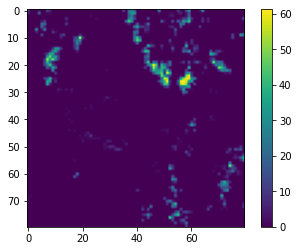

In [10]:
heatmap2d(brick_kilns)

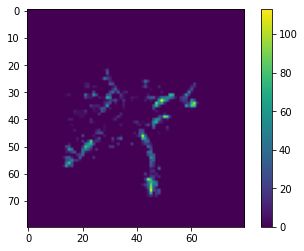

In [11]:
heatmap2d(industries)

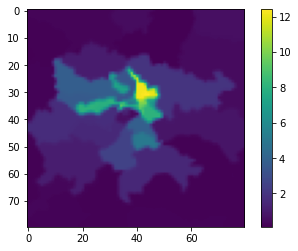

In [12]:
heatmap2d(population_density)

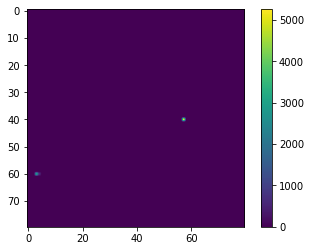

In [13]:
heatmap2d(power_plants)

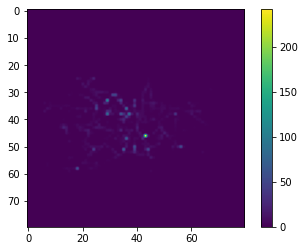

In [14]:
heatmap2d(traffic_12)

In [15]:
brick_kilns = torch.unsqueeze(torch.unsqueeze(torch.tensor(brick_kilns,dtype=torch.float),0),0).cuda()
industries = torch.unsqueeze(torch.unsqueeze(torch.tensor(industries,dtype=torch.float),0),0).cuda()
power_plants = torch.unsqueeze(torch.unsqueeze(torch.tensor(power_plants,dtype=torch.float),0),0).cuda()
population_density = torch.unsqueeze(torch.unsqueeze(torch.tensor(population_density,dtype=torch.float),0),0).cuda()
traffic_06 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_06,dtype=torch.float),0),0).cuda()
traffic_12 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_12,dtype=torch.float),0),0).cuda()
traffic_18 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_18,dtype=torch.float),0),0).cuda()
traffic_00 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_00,dtype=torch.float),0),0).cuda()

# Gaussian-Plume Model for Point Source

## Core Gaussian-Plume Dispersion Formula

In [16]:
# def gaussian_plume(src, dest, intensity, wind_speed, alpha, H, z=6.5, a=213, c=459.7, d=2.094, offset=100):
#     # import pdb; pdb.set_trace()
#     if(intensity>0):
#         wind_speed[1] = -wind_speed[1]
#         unit_wind_vector = wind_speed/math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#         wind_magnitude = math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#         if(src!=dest):
#             unit_distance_vector = np.array([dest[1]-src[1], dest[0]-src[0]])/math.sqrt(math.pow((dest[1]-src[1]),2)+math.pow((dest[0]-src[0]),2)) 
#             #reversing as lat=y-axis and long=x-axis
#             distance = math.sqrt(math.pow((dest[1]-src[1]),2)+math.pow((dest[0]-src[0]),2))*math.pow(10,5)
#             distance_vector = distance * unit_distance_vector
#             x = np.dot(distance_vector, unit_wind_vector)
#             if(x<=0):
#                 return(0.0)
#             else:
#                 x = min(x,distance)
#                 y = math.sqrt(math.pow(distance,2)-math.pow(x,2))
#                 x = max(x,offset)
#         else:
#             x = offset
#             y = 0
#         sigma_z = c*math.pow(x*0.001,d)
#         sigma_z = min(5000,sigma_z)
#         sigma_y = a*math.pow(x*0.001,0.894)
#         concentration = ((alpha*intensity)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-math.pow(y,2)/math.pow(2*sigma_y,2))*\
#         (math.exp(-(math.pow(z-H,2)/math.pow(2*sigma_z,2)))+math.exp(-(math.pow(z+H,2)/math.pow(2*sigma_z,2))))
#         return(concentration)
#     else:
#         return 0

## Computing concentration at a sensor because of different sources

In [17]:
# import skimage.measure
# bkl_40 = skimage.measure.block_reduce(brick_kilns, (2,2), np.sum)
# ind_40 = skimage.measure.block_reduce(industries, (2,2), np.sum)
# pop_40 = skimage.measure.block_reduce(population_density, (2,2), np.sum)
# ppl_40 = skimage.measure.block_reduce(power_plants, (2,2), np.sum)

In [18]:
# def compute_concentration(dest, ts, wind_speed, alpha=8.4*math.pow(10,3),\
#                           H={'traffic':0, 'brick_kilns':25, 'population':10, 'industry':30, 'power':400}):
    
#     # Find the correct timestamp for the traffic sources
#     if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
#         traffic_srcs = traffic_06
#     elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
#         traffic_srcs = traffic_12
#     elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
#         traffic_srcs = traffic_18
#     else:
#         traffic_srcs = traffic_00
    
#     # Convert traffic sources into 40x40    
#     # tra_40 = skimage.measure.block_reduce(traffic_srcs, (2,2), np.sum)
    
#     # Initialize the different source contributions
#     contrib_brick, contrib_industry, contrib_population, contrib_traffic, contrib_power = 0.0,0.0,0.0,0.0,0.0
    
#     # Define the grid of sources under consideration
#     idx_x = int((dest[1]-76.85)/0.01)
#     idx_y = 79-int((dest[0]-28.2)/0.01)
#     src_radius = 7
#     dest = (28.2+((79-idx_y)*0.01)+0.005, 76.85+(idx_x*0.01)+0.005)
        
#     for i in range(max(idx_y-src_radius,0), min(idx_y+src_radius+1,79)):
#         for j in range(max(idx_x-src_radius,0), min(idx_x+src_radius+1,79)):
#             src = (28.2+((79-j)*0.01)+0.005, 76.85+(i*0.01)+0.005)
#             contrib_brick += gaussian_plume(src, dest, brick_kilns[i,j], wind_speed, alpha, H['brick_kilns'])
#             contrib_industry += gaussian_plume(src, dest, industries[i,j], wind_speed, alpha, H['industry'])
#             contrib_population += gaussian_plume(src, dest, population_density[i,j], wind_speed, alpha, H['population'])
#             contrib_traffic += gaussian_plume(src, dest, traffic_srcs[i,j], wind_speed, alpha, H['traffic'])
#             contrib_power += gaussian_plume(src, dest, power_plants[i,j], wind_speed, alpha, H['power'])
            
#     total_concentration = contrib_brick + contrib_industry + contrib_population + contrib_traffic + contrib_power
#     contrib = [contrib_brick, contrib_industry, contrib_population, contrib_traffic]
#     return total_concentration

In [19]:
def gpdm_filter(H, wind_speed, size):
    filt = torch.zeros((size,size)).cuda()
    dest_x, dest_y = int(size/2), int(size/2)
    wind_speed[1] = -wind_speed[1]
    for i in range(size):
        for j in range(size):
            src_x, src_y = i, j
            unit_wind_vector = wind_speed/math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
            wind_magnitude = math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
            if(dest_x!=src_x and dest_y!=src_y):
                unit_distance_vector = np.array([dest_x-src_x, dest_y-src_y])/math.sqrt(math.pow((dest_x-src_x),2)+math.pow((dest_y-src_y),2))
                distance = math.sqrt(math.pow((dest_x-src_x),2)+math.pow((dest_y-src_y),2))*math.pow(10,5)
                distance_vector = distance * unit_distance_vector
                x = np.dot(distance_vector, unit_wind_vector)
                if(x<=0):
                    continue
                else:
                    if(math.pow(distance,2)-math.pow(x,2)<0):
                        x = distance
                    y = math.sqrt(math.pow(distance,2)-math.pow(x,2))
                    x = max(x,100)
            else:
                x = 100
                y = 0
            sigma_z = 459.7*math.pow(x*0.001,2.094)
            sigma_z = min(5000,sigma_z)
            sigma_y = 213*math.pow(x*0.001,0.894)
            filt[i,j] = (math.pow(10,9)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-math.pow(y,2)/math.pow(2*sigma_y,2))*\
        (math.exp(-(math.pow(6.5-H,2)/math.pow(2*sigma_z,2)))+math.exp(-(math.pow(6.5+H,2)/math.pow(2*sigma_z,2))))
    return(torch.unsqueeze(filt,0))

In [28]:
def compute_filters(ts_array, H={'traffic':0, 'brick_kilns':25, 'population':10, 'industry':30, 'power':400}):
    
    ts_filters = {'traffic':[], 'brick_kilns':[], 'population':[], 'industry':[], 'power':[]}
    src_radius = 7
    
    for ts in ts_array:
        wind_speed = get_wind_speed_estimate(ts)
        ts_filters['brick_kilns'].append(gpdm_filter(H['brick_kilns'], wind_speed, 2*src_radius+1))
        ts_filters['industry'].append(gpdm_filter(H['industry'], wind_speed, 2*src_radius+1))
        ts_filters['population'].append(gpdm_filter(H['population'], wind_speed, 2*src_radius+1))
        ts_filters['traffic'].append(gpdm_filter(H['traffic'], wind_speed, 2*src_radius+1))
        ts_filters['power'].append(gpdm_filter(H['power'], wind_speed, 2*src_radius+1))
    for srcs in list(ts_filters.keys()):
        ts_filters[srcs] = torch.stack(ts_filters[srcs]) 
    return(ts_filters)

In [20]:
def convolve_at_sensors(sensors, ts_array, alpha, ts_filter):    
    
    concentrations_at_sensors = []
    src_radius = 7
    
    for sensor in sensors:
        dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
        idx_x = int((dest[1]-76.85)/0.01)
        idx_y = 79-int((dest[0]-28.2)/0.01)
        
        contrib_brick = torch.nn.functional.conv2d(ts_filter['brick_kilns'], \
                                                   brick_kilns[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_industry = torch.nn.functional.conv2d(ts_filter['industry'], \
                                                   industries[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_population = torch.nn.functional.conv2d(ts_filter['population'], \
                                                   population_density[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_06 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_06[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_00 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_00[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_12 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_12[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_18 = torch.nn.functional.conv2d(ts_filter['traffic'], \
                                                   traffic_18[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_power = torch.nn.functional.conv2d(ts_filter['power'], \
                                                   power_plants[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic = torch.zeros_like(contrib_traffic_06)
        for i in range(len(ts_array)):
            ts = ts_array[i]
            if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
                contrib_traffic[i] = contrib_traffic_06[i]
            elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
                contrib_traffic[i] = contrib_traffic_12[i]
            elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
                contrib_traffic[i] = contrib_traffic_18[i]
            else:
                contrib_traffic[i] = contrib_traffic_00[i]
            
        total_concentration = contrib_brick + contrib_industry + contrib_population + contrib_traffic + contrib_power
        total_concentration = torch.squeeze(total_concentration)
        concentrations_at_sensors.append(alpha*total_concentration)
    return(concentrations_at_sensors)

In [64]:
# def convolve_entire_field(ts, wind_speed, alpha, ts_filter):
#     # Find the correct timestamp for the traffic sources
#     if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
#         traffic_srcs = traffic_06
#     elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
#         traffic_srcs = traffic_12
#     elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
#         traffic_srcs = traffic_18
#     else:
#         traffic_srcs = traffic_00
        
#     src_radius = 7
    
#     contrib_brick = torch.nn.functional.conv2d(brick_kilns,ts_filter['brick_kilns'],padding='same')
#     contrib_industry = torch.nn.functional.conv2d(industries,ts_filter['industry'],padding='same')
#     contrib_population = torch.nn.functional.conv2d(population_density,ts_filter['population'],padding='same')
#     contrib_traffic = torch.nn.functional.conv2d(traffic_srcs,ts_filter['traffic'],padding='same')
#     contrib_power = torch.nn.functional.conv2d(power_plants,ts_filter['power'],padding='same')
#     total_concentration = contrib_brick + contrib_industry + contrib_population + contrib_traffic + contrib_power
    
#     return(total_concentration*alpha)

## Find nearest wind speed data

In [24]:
def get_wind_speed_estimate(ts):
    ts = np.array([ts]).astype('datetime64[ns]')[0]
    if(pd.Timestamp(ts).hour in [5,11,17,23]):
        ts = ts+np.timedelta64(30,'m')
    else:
        ts = ts-np.timedelta64(30,'m')

    ws = df_ws.loc[ts].values
    ws = ws*(5.0/18)
    return(ws)

## Filtering data points based on time so that wind data is only 30 minutes in deviation.

In [25]:
def check_timestamp(ts):
    ts = np.array([ts]).astype('datetime64[ns]')[0]
    if(pd.Timestamp(ts).hour in [5,11,17,23]):
        ts = ts+np.timedelta64(30,'m')
    else:
        ts = ts-np.timedelta64(30,'m')

    try:
        ws = df_ws.loc[ts].values
        return(True)
    except:
        return(False)

ws_timestamps = df_ws.index.to_numpy()
ts_array = np.array(list(set(data.dropna().index.get_level_values("timestamp_round").to_numpy())))
ts_array = np.sort(ts_array)
df_timestamps = pd.DataFrame(ts_array)
ts_array = ts_array[df_timestamps[0].apply(lambda x: True if x.hour in [5,6,11,12,17,18,23,0] else False).to_numpy().astype(np.bool)]
df_timestamps = pd.DataFrame(ts_array)
ts_array = ts_array[df_timestamps[0].apply(check_timestamp).to_numpy().astype(np.bool)]

In [26]:
np.random.seed(42)
np.random.shuffle(ts_array)
train, test = ts_array[:int(0.8*len(ts_array))], ts_array[int(0.8*len(ts_array)):]

# MLE Training of Model 

In [26]:
# def obj_hsp(ts,alpha):
#     wind_speed = get_wind_speed_estimate(ts)
#     sensors = df.columns
#     sensors = df.loc[ts][sensors].dropna().index.to_numpy() 
#     obj = 0
#     for sensor in sensors:
#         dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
#         computed_val = compute_concentration(dest=dest, ts=ts, alpha=alpha, wind_speed=wind_speed)
#         measured_val = df.loc[ts][sensor]
#         obj = obj + (measured_val-computed_val)**2  
#     return(obj,len(sensors))

# def objective(alpha):
#     obj_sens = np.array(Parallel(n_jobs=15)(delayed(obj_hsp)(train[i],alpha) for i in range(len(train))))
#     obj = np.sum(obj_sens[:,0])
#     N = np.sum(obj_sens[:,1])
#     rmse = math.sqrt(obj/N)
#     return(rmse)

# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# space = hp.uniform('alpha', 0.01, 100)

# trials = Trials()

# best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials, trials_save_file='trials_alpha_100.hyperopt')

In [27]:
# with open('trials_alpha_100.hyperopt', 'rb') as f:
#     trials = pkl.load(f)

# print(len(trials.losses()),min(trials.losses()))

# idx = trials.losses().index(min(trials.losses()))
# best_list_dict = trials.trials[idx]['misc']['vals']
# best = {key:value[0] for key,value in best_list_dict.items()}
# best

In [34]:
ts_filters = compute_filters(train)

In [71]:
%%time
alpha = 1
comp, mes = 0,0
sensors = df.columns
comp_values = torch.stack(convolve_at_sensors(sensors, train, alpha, ts_filters),1)
mes_values = torch.tensor(df.loc[train].to_numpy()).cuda()
mask = mes_values.isnan().long()
comp_values = comp_values*mask
mes = torch.nansum(mes_values)
comp = torch.sum(comp_values)
print(mes/comp)

tensor(3.6545e-07, device='cuda:0', dtype=torch.float64)
CPU times: user 3.31 s, sys: 999 µs, total: 3.31 s
Wall time: 3.31 s


# Evaluation of Gaussian Plume Model

In [ ]:
def evaluate(alpha):
    obj, N = 0, 0
    ape = []
    for i in tqdm(range(len(test))):
        ts = test[i]
        wind_speed = get_wind_speed_estimate(ts)
        sensors = df.columns
        sensors = df.loc[ts][sensors].dropna().index.to_numpy()
        for sensor in sensors:
            dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
            computed_val = compute_concentration(dest=dest, ts=ts, wind_speed=wind_speed, alpha=alpha)
            measured_val = df.loc[ts][sensor]
            obj = obj + (measured_val-computed_val)**2
            N = N+1
            ape.append((abs(measured_val-computed_val)/measured_val)*100)
            
    rmse = math.sqrt(obj/N)
    mape = np.mean(np.array(ape))
    return(rmse, mape)

In [ ]:
rmse, mape = evaluate(8460.141825104929)

In [ ]:
print(rmse, mape)

# Mapping and Source Apportionment of Hotspots

In [ ]:
def map_timestamp(alpha, ts):
    wind_speed = get_wind_speed_estimate(ts)
    print(wind_speed)
    # region_lat_b, region_lat_t, region_long_l, region_long_r = 28.39, 28.78, 77.01, 77.40
    region_lat_b, region_lat_t, region_long_l, region_long_r = 28.20, 29.00, 76.85, 77.75
    # res = 39
    res = 80
    map_hsp = np.zeros((res,res))
    for i in tqdm(range(res)):
        for j in range(res):
            # lat = region_lat_b + (region_lat_t-region_lat_b)*((res-j-1)*1.0/res)
            # long = region_long_l + (region_long_r - region_long_l)*(i*1.0/res)
            cord = ((28.2+((79-j)*0.01)+0.005, 76.85+(i*0.01)+0.005))
            # cord = (lat,long)
            val = compute_concentration(dest=cord, ts=ts, wind_speed=wind_speed, alpha=alpha)
            map_hsp[i,j] = val
    return(map_hsp)

In [ ]:
map_array = map_timestamp(8460.141825104929, test[98])

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(map_array, cmap='viridis', interpolation='nearest', alpha=0.4)
plt.axis('off')
plt.colorbar()
# plt.show()
plt.savefig('heatmap.png')

In [ ]:
# region_lat_b, region_lat_t, region_long_l, region_long_r = 28.39, 28.78, 77.01, 77.40
region_lat_b, region_lat_t, region_long_l, region_long_r = 28.20, 29.00, 76.85, 77.65
subset_locs = locs[(locs['Latitude']<region_lat_t) & (locs['Latitude']>region_lat_b) &\
                   (locs['Longitude']<region_long_r) & (locs['Longitude']>region_long_l)]

lat_lims = region_lat_b, region_lat_t
lon_lims = region_long_l, region_long_r
lat_center, lon_center = (region_lat_b + region_lat_t)/2, (region_long_l + region_long_r)/2

extent = tilemapbase.Extent.from_lonlat(region_long_l, region_long_r, region_lat_b, region_lat_t)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(2,2), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in subset_locs.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=10, label='Our sensors')
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b', s=10, label='CPCB/DPCC/IMD')
    # ax.text(x, y, row.Index, fontsize=3)

# ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)
fig.savefig('hsp_map.png')
plt.show()

In [ ]:
hsp_map = Image.open('./hsp_map.png')
heatmap = Image.open('./heatmap.png')

heatmap = heatmap.resize(hsp_map.size)

hsp_map.paste(heatmap,(0,0),heatmap)

hsp_map

In [ ]:
scipy.signal.convolve2d(brick_kilns[5:20,5:20],ts_filters[train[0]]['brick_kilns'],mode='valid')

In [ ]:
scipy.signal.convolve2d(brick_kilns,ts_filters[train[0]]['brick_kilns'],mode='same')[12,12]

In [28]:
sensors = df.columns
cell_assign = np.zeros((80,80))
sensor_grids = []
for sensor in sensors:
    dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
    idx_x = int((dest[1]-76.85)/0.01)
    idx_y = 79-int((dest[0]-28.2)/0.01)
    cell_assign[idx_x,idx_y] += 1
    sensor_grids.append(idx_x*100+idx_y)

In [29]:
np.where(cell_assign==3)

(array([34]), array([43]))

In [26]:
overlapping_grids = [2936,3339,3443]

In [34]:
np.where(np.array(sensor_grids)==2936)

(array([50, 51]),)

In [23]:
sensor_grids[38]

(39, 36)

In [35]:
duplicates = [1,13,34,9,24,50,51]

In [36]:
sensors[duplicates]

Index(['1FD7', '97D7', 'E8E4', '603A', 'CBC7', 'Pusa_DPCC', 'Pusa_IMD'], dtype='object', name='field_egg_id')

In [37]:
df[sensors[duplicates]]=np.nan

In [38]:
df

field_egg_id,113E,1FD7,20CA,2E9C,3ACF,498F,4BE7,56C3,5D7A,603A,...,Pusa_DPCC,Pusa_IMD,RKPuram_DPCC,Rohini_DPCC,Shadipur_CPCB,Sirifort_CPCB,SoniaVihar_DPCC,SriAurobindoMarg_DPCC,VivekVihar_DPCC,Wazirpur_DPCC
timestamp_round,,,,,,,,,,,,,,,,,,,,,
2018-05-01 00:00:00+05:30,NaN,NaN,NaN,NaN,NaN,63.166667,NaN,NaN,58.945055,NaN,...,NaN,NaN,68.00,79.0,51.47,NaN,79.83,NaN,70.0,94.0
2018-05-01 01:00:00+05:30,NaN,NaN,NaN,NaN,NaN,59.333333,NaN,NaN,48.243243,NaN,...,NaN,NaN,89.00,61.0,39.93,NaN,70.83,NaN,59.0,77.0
2018-05-01 02:00:00+05:30,NaN,NaN,NaN,NaN,NaN,55.083333,NaN,NaN,40.970874,NaN,...,NaN,NaN,68.00,61.0,NaN,NaN,59.00,NaN,52.0,64.0
2018-05-01 03:00:00+05:30,NaN,NaN,NaN,NaN,NaN,56.000000,NaN,NaN,37.344086,NaN,...,NaN,NaN,55.00,56.0,NaN,NaN,51.58,NaN,53.0,56.0
2018-05-01 04:00:00+05:30,NaN,NaN,NaN,NaN,NaN,64.083333,NaN,NaN,37.708333,NaN,...,NaN,NaN,52.00,52.0,NaN,NaN,45.50,NaN,52.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-31 19:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,119.00,117.0,91.59,112.25,149.00,77.75,140.5,87.0
2020-10-31 20:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,149.00,158.0,106.34,131.25,160.00,99.75,170.0,111.0
2020-10-31 21:00:00+05:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,167.50,243.0,132.31,159.25,191.00,129.00,214.0,149.0
